<a href="https://colab.research.google.com/github/Vineet2107/EEG_Pipeline/blob/main/ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, BatchNormalization, Dense, Flatten, Add
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt


In [4]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype(np.float32)
test_images = test_images.astype(np.float32)

train_images = train_images[:5000] / 255.
train_labels = train_labels[:5000]

test_images = test_images / 255.

train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

4423680/4422102 [==============================] - 0s 0us/step


In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels))
train_dataset = train_dataset.batch(32)

test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels))
test_dataset = test_dataset.batch(32)

In [6]:
image_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [7]:
class ResidualBlock(Layer):

    def __init__(self, **kwargs):
        super(ResidualBlock, self).__init__(**kwargs)
        
    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure 
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape)
        self.conv_1 = Conv2D(input_shape[-1], (3,3), padding='same')
        self.batch_norm_2 = BatchNormalization()
        self.conv_2 = Conv2D(input_shape[-1], (3,3), padding='same')
        
        
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        x = self.batch_norm_1(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv_1(x)
        x = self.batch_norm_2(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv_2(x)

        return tf.add(inputs, x)

In [8]:
test_model = tf.keras.Sequential([ResidualBlock(input_shape=(28, 28, 1), name="residual_block")])
test_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
residual_block (ResidualBloc (None, 28, 28, 1)         28        
Total params: 28
Trainable params: 24
Non-trainable params: 4
_________________________________________________________________


In [9]:
class FiltersChangeResidualBlock(Layer):

    def __init__(self, out_filters, **kwargs):
        """
        The class initialiser should call the base class initialiser, passing any keyword
        arguments along. It should also set the number of filters as a class attribute.
        """
        super(FiltersChangeResidualBlock, self).__init__(**kwargs)
        self.out_filters = out_filters
        
        
        
    def build(self, input_shape):
        """
        This method should build the layers according to the above specification. Make sure 
        to use the input_shape argument to get the correct number of filters, and to set the
        input_shape of the first layer in the block.
        """
        self.batch_norm_1 = BatchNormalization(input_shape=input_shape)
        self.conv_1 = Conv2D(input_shape[-1], (3,3), padding='same')
        self.batch_norm_2 = BatchNormalization()
        self.conv_2 = Conv2D(self.out_filters, (3,3), padding='same')

        self.conv_3 = Conv2D(self.out_filters, (1,1)) 
        
        
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the build method.
        """
        x = self.batch_norm_1(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv_1(x)
        x = self.batch_norm_2(inputs, training=training)
        x = tf.nn.relu(x)
        x = self.conv_2(x)
        final = self.conv_3(inputs)
        
        return tf.add(x, final)

In [10]:
test_model = tf.keras.Sequential([FiltersChangeResidualBlock(16, input_shape=(32, 32, 3), name="fc_resnet_block")])
test_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc_resnet_block (FiltersChan (None, 32, 32, 16)        620       
Total params: 620
Trainable params: 608
Non-trainable params: 12
_________________________________________________________________


In [11]:
class ResNetModel(Model):

    def __init__(self, **kwargs):
        """
        The class initialiser should call the base class initialiser, passing any keyword
        arguments along. It should also create the layers of the network according to the
        above specification.
        """
        super(ResNetModel, self).__init__(**kwargs)

        self.conv_1 = Conv2D(32, (7,7), strides=2)
        self.resnet_1 = ResidualBlock()
        self.conv_2 = Conv2D(32, (3,3), strides=2)
        self.resnet_2 = FiltersChangeResidualBlock(64)
        self.flatten = Flatten()
        self.dense = Dense(10, activation='softmax')
        
        
        
    def call(self, inputs, training=False):
        """
        This method should contain the code for calling the layer according to the above
        specification, using the layer objects set up in the initialiser.
        """
        x = self.conv_1(inputs)
        x = self.resnet_1(x, training)
        x = self.conv_2(inputs)
        x = self.resnet_2(x, training)
        x = self.flatten(x)
        
        return self.dense(x)

In [12]:
resnet_model = ResNetModel()

In [13]:
optimizer_obj = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_obj = tf.keras.losses.SparseCategoricalCrossentropy()

In [14]:
@tf.function
def grad(model, inputs, targets, loss):
    """
    This function should compute the loss and gradients of your model, corresponding to
    the inputs and targets provided. It should return the loss and gradients.
    """
    with tf.GradientTape() as tape:
      predictions = model(inputs)
      loss_value = loss(targets, predictions)
      grads = tape.gradient(loss_value, model.trainable_variables)
        
    return loss_value, grads

In [15]:
def train_resnet(model, num_epochs, dataset, optimizer, loss, grad_fn):
    """
    This function should implement the custom training loop, as described above. It should 
    return a tuple of two elements: the first element is a list of loss values per epoch, the
    second is a list of accuracy values per epoch
    """
    train_loss_results = []
    train_accuracy_results = []
    for epoch in range(num_epochs):

      epoch_loss_avg = tf.keras.metrics.Mean()
      epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

      for x, y in train_dataset:

        loss_value, grads = grad_fn(model, x, y, loss)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        epoch_loss_avg(loss_value)
        epoch_accuracy(to_categorical(y), model(x))

      train_loss_results.append(epoch_loss_avg.result())
      train_accuracy_results.append(epoch_accuracy.result())

    return train_loss_results, train_accuracy_results

In [16]:
train_loss_results, train_accuracy_results = train_resnet(resnet_model, 8, train_dataset, optimizer_obj, 
                                                          loss_obj, grad)

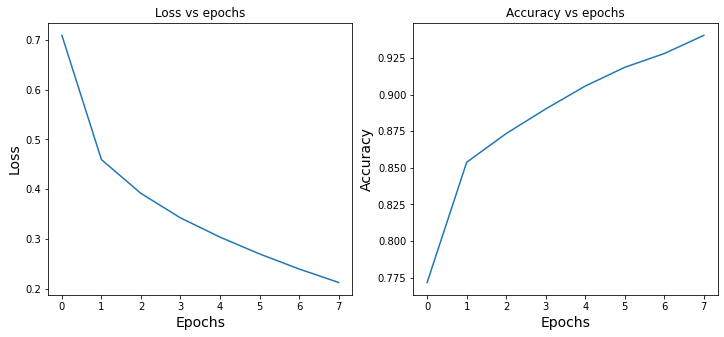

In [17]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 5))

axes[0].set_xlabel("Epochs", fontsize=14)
axes[0].set_ylabel("Loss", fontsize=14)
axes[0].set_title('Loss vs epochs')
axes[0].plot(train_loss_results)

axes[1].set_title('Accuracy vs epochs')
axes[1].set_ylabel("Accuracy", fontsize=14)
axes[1].set_xlabel("Epochs", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

In [18]:
epoch_loss_avg = tf.keras.metrics.Mean()
epoch_accuracy = tf.keras.metrics.CategoricalAccuracy()

for x, y in test_dataset:
    model_output = resnet_model(x)
    epoch_loss_avg(loss_obj(y, model_output))  
    epoch_accuracy(to_categorical(y), model_output)

print("Test loss: {:.3f}".format(epoch_loss_avg.result().numpy()))
print("Test accuracy: {:.3%}".format(epoch_accuracy.result().numpy()))

Test loss: 0.562
Test accuracy: 83.370%


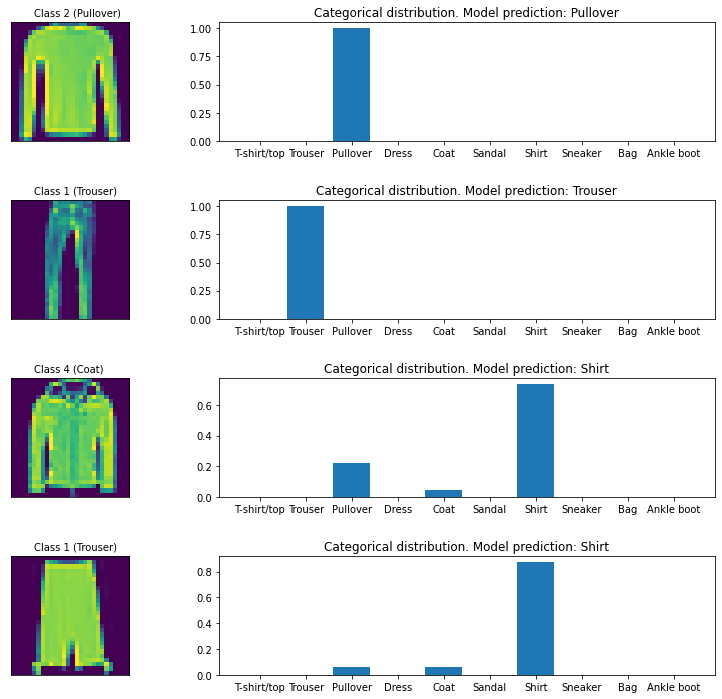

In [19]:
num_test_images = test_images.shape[0]

random_inx = np.random.choice(test_images.shape[0], 4)
random_test_images = test_images[random_inx, ...]
random_test_labels = test_labels[random_inx, ...]

predictions = resnet_model(random_test_images)

fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.subplots_adjust(hspace=0.5, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, random_test_images, random_test_labels)):
    axes[i, 0].imshow(np.squeeze(image))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(5., -2., f'Class {label} ({image_labels[label]})')
    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_xticklabels(image_labels, rotation=0)
    pred_inx = np.argmax(prediction)
    axes[i, 1].set_title(f"Categorical distribution. Model prediction: {image_labels[pred_inx]}")
    
plt.show()